In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.graphics.correlation as sgc
from statsmodels.graphics.gofplots import qqplot
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence

In [2]:
# Read the data
environmental_indicators = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Data/regression_sprint/enviro_indicators.csv', index_col=0)
environmental_indicators.head(10)

,forest_coverage,biodiversity_index,protected_areas,deforestation_rate,carbon_sequestration,soil_erosion,land_degradation,rural_population,population_density
Country,,,,,,,,,
Vietnam,36.217808,6.505159,14.832708,36.583106,53.128459,7.987880,55.020903,35.912142,468.715839
Guinea-Bissau,76.550001,94.888554,23.994363,123.384939,279.836286,13.013811,41.655073,34.639379,351.054600
Bosnia and Herzegovina,61.239576,96.563203,9.932348,115.743745,237.834951,13.037065,26.951490,78.380633,289.329973
Lesotho,51.906094,80.839735,33.076894,111.752369,149.948515,11.179719,27.460479,43.585863,57.616482
Indonesia,20.921305,30.461377,7.609273,46.450326,103.939415,2.715506,46.297784,73.522793,311.353541
Singapore,20.919616,9.767211,39.541043,25.249501,201.926827,16.870747,54.855513,57.868318,495.126387
Saint Lucia,14.065853,68.423303,32.028567,76.130581,474.309367,7.094821,54.354321,67.688678,78.641167
Turkmenistan,70.632330,44.015249,11.955049,73.358093,195.441319,4.543852,48.993777,50.158226,263.981530
Kenya,52.078051,12.203823,5.193274,36.843972,283.455780,1.774728,42.101582,54.614233,439.912805


# **Exercise 1**
Print the first few rows of the dataset, the summary statistics, and check for missing values. Doing this provides an overview of the structure of the data and highlights whether there are any issues with missing data.

In [3]:
# Print the first few rows of the dataset
print("First few rows of the dataset:")
print(environmental_indicators.head())

# Print the summary statistics of the dataset
print("\nSummary statistics of the dataset:")
print(environmental_indicators.describe())

# Check for missing values in the dataset
print("\nMissing values in the dataset:")
print(environmental_indicators.isnull().sum())

# Exclude non-numeric columns before computing the correlation matrix
numeric_columns = environmental_indicators.select_dtypes(include=[np.number])


First few rows of the dataset:
                        forest_coverage  biodiversity_index  protected_areas  \
Country                                                                        
Vietnam                       36.217808            6.505159        14.832708   
Guinea-Bissau                 76.550001           94.888554        23.994363   
Bosnia and Herzegovina        61.239576           96.563203         9.932348   
Lesotho                       51.906094           80.839735        33.076894   
Indonesia                     20.921305           30.461377         7.609273   

                        deforestation_rate  carbon_sequestration  \
Country                                                            
Vietnam                          36.583106             53.128459   
Guinea-Bissau                   123.384939            279.836286   
Bosnia and Herzegovina          115.743745            237.834951   
Lesotho                         111.752369            149.948515   


# **Exercise 2**
Create a correlation matrix using the columns in the data. We do this to see whether there are potentially strong relationships between the independent variables and the dependant variable, but it can also be used to investigate potential multicollinearity between the independent variables.

In [9]:
# Compute the correlation matrix
correlation_matrix = numeric_columns.corr()

# Highlight correlations above a certain threshold (e.g., 0.7 or -0.7)
styled_correlation_matrix = correlation_matrix.style.applymap(lambda x: 'background-color: red' if abs(x) > 0.7 and x != 1 else '')

# Display the correlation matrix
print("Correlation Matrix:")
display(styled_correlation_matrix)

Correlation Matrix:


/tmp/ipython-input-2544989063.py:5: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_correlation_matrix = correlation_matrix.style.applymap(lambda x: 'background-color: red' if abs(x) > 0.7 and x != 1 else '')


,forest_coverage,biodiversity_index,protected_areas,deforestation_rate,carbon_sequestration,soil_erosion,land_degradation,rural_population,population_density
forest_coverage,1.000000,0.274022,0.108666,0.556136,0.053950,-0.109275,0.154287,0.022843,0.027884
biodiversity_index,0.274022,1.000000,-0.067212,0.922463,0.009418,-0.062205,-0.136184,0.042478,-0.135042
protected_areas,0.108666,-0.067212,1.000000,0.120202,0.146215,0.321587,-0.113558,0.172193,-0.001360
deforestation_rate,0.556136,0.922463,0.120202,1.000000,0.063443,-0.082024,-0.092885,0.105760,-0.126157
carbon_sequestration,0.053950,0.009418,0.146215,0.063443,1.000000,0.237919,0.268428,-0.017830,-0.344947
soil_erosion,-0.109275,-0.062205,0.321587,-0.082024,0.237919,1.000000,-0.110673,0.146636,0.046528
land_degradation,0.154287,-0.136184,-0.113558,-0.092885,0.268428,-0.110673,1.000000,-0.085273,-0.137509
rural_population,0.022843,0.042478,0.172193,0.105760,-0.017830,0.146636,-0.085273,1.000000,0.226600
population_density,0.027884,-0.135042,-0.001360,-0.126157,-0.344947,0.046528,-0.137509,0.226600,1.000000


Based on the correlation matrix above, the variables that appear to be strongly related (absolute correlation > 0.7) are:

*   `biodiversity_index` and `deforestation_rate` (correlation of approximately 0.92)

It is, however, difficult to view the data well in table format. It might be more useful to display it as a heatmap.

1) Use the statsmodels.graphics.correlation package to show the correlation heatmap for the variables. 2) What relationships exist?

<Figure size 1000x800 with 0 Axes>

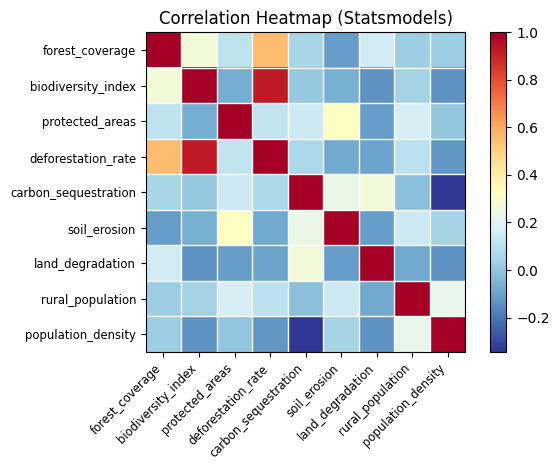

In [8]:
# Create the correlation heatmap
plt.figure(figsize=(10, 8))
fig = sgc.plot_corr(correlation_matrix, xnames=correlation_matrix.columns)

# Add title
plt.title("Correlation Heatmap (Statsmodels)")

# Show the plot
plt.show()

Based on the heatmap, we can see that there is some form of correlation between the following variables: 1) deforestation_rate and forest_coverage 2) soil_erosion and protected_areas 3) soil_erosion and carbon_sequestration 4) land_degradation and carbon_sequestration 5) deforestation_rate and biodiversity_index 6) biodiversity_index and forest_coverage

Realistically, we can see that forest_coverage is related to deforestation_rate in some way, as there needs to be a forest before it can be deforested. deforestation_rate also has a relatively strong relationship with biodiversity_index.

# **Exercise 3**
Knowing what we know about the relationships between the variables, it's time to build our regression model. To get started, include all the numeric variables in the model. Remember that biodiversity_index is the dependent variable.

Print the summary of the fitted model.

In [10]:
independent_cols = ['forest_coverage',  'protected_areas',
       'deforestation_rate', 'carbon_sequestration', 'soil_erosion',
       'land_degradation', 'rural_population', 'population_density']

dependent_var = 'biodiversity_index'

In [11]:
# Generating the regression string
formula_str = dependent_var+ ' ~ ' + ' + '.join(independent_cols)
formula_str
# Construct and fit the model
model = smf.ols(formula=formula_str, data=environmental_indicators)
fitted = model.fit()

# Print the summary of the fitted model
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:     biodiversity_index   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     85.25
Date:                Thu, 06 Nov 2025   Prob (F-statistic):           2.99e-15
Time:                        10:20:49   Log-Likelihood:                -101.24
No. Observations:                  32   AIC:                             220.5
Df Residuals:                      23   BIC:                             233.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.2536 

There is a note warning of potential multicollinearity. In addition, some of the p-values on the coefficients are quite high (larger than we would like). It might be worth looking at which variables seem to be correlated with the dependent variable, keeping those, and maybe dropping a few other variables where there might be multicollinearity. The issue with this is that our model might be highly unstable.

# **Exercise 4**
Create another version of the model with fewer independent variables and see if the warning can be silenced.

In [12]:
# dropped population density, land_degradation, carbon sequestration
independent_cols_reduced = ['forest_coverage',  'protected_areas',
       'deforestation_rate', 'soil_erosion',
        'rural_population']

dependent_var = 'biodiversity_index'

In [13]:
# Generating the regression string
formula_str = dependent_var+ ' ~ ' + ' + '.join(independent_cols_reduced)
formula_str
# Construct and fit the model
model = smf.ols(formula=formula_str, data=environmental_indicators)
fitted = model.fit()

# Print the summary of the fitted model
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:     biodiversity_index   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     146.1
Date:                Thu, 06 Nov 2025   Prob (F-statistic):           3.59e-18
Time:                        10:25:09   Log-Likelihood:                -102.07
No. Observations:                  32   AIC:                             216.1
Df Residuals:                      26   BIC:                             224.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.4728      4

# **Exercise 5**
Evaluate the accuracy and reliability of the multiple linear regression model by conducting various diagnostic tests.

Check for linearity by visually inspecting scatter plots between each independent variable and the biodiversity index. This will help in understanding whether the relationship between the independent variables and the biodiversity index is linear.

What can you see from the charts? Are there any linear relationships visible?

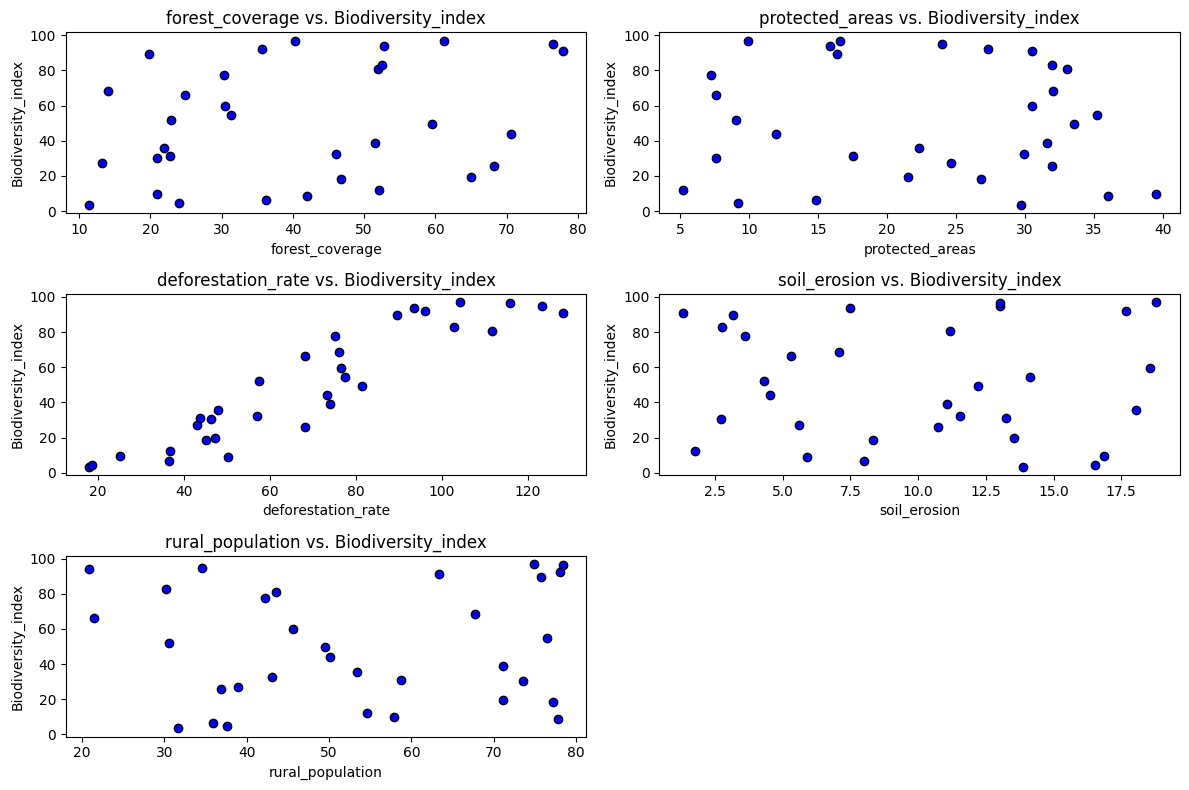

In [19]:
# Determine the number of rows and columns for subplots
num_cols = 2
num_rows = (len(independent_cols_reduced) + num_cols - 1) // num_cols

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
axs = axs.ravel()

# Iterate over each independent variable and create scatter plot against biodiversity index
for index, column in enumerate(independent_cols_reduced):
    axs[index].scatter(x=environmental_indicators[column], y=environmental_indicators['biodiversity_index'], color='blue', edgecolor='k')
    axs[index].set_title("{} vs. Biodiversity_index".format(column), fontsize=12)
    axs[index].set_xlabel(column, fontsize=10)
    axs[index].set_ylabel("Biodiversity_index", fontsize=10)

# Hide any unused subplots
for i in range(len(independent_cols_reduced), num_rows * num_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

The only variable that shows a relatively linear relationship with biodiversity_index is deforestation_rate.

# **Exercise 6**
Visualise the relationship between predictor variables and model residuals to assess the independence of residuals using scatter plots. Do we see any obvious dependence of residuals? How would we know?

In [15]:
reduced_matrix = environmental_indicators[independent_cols_reduced]

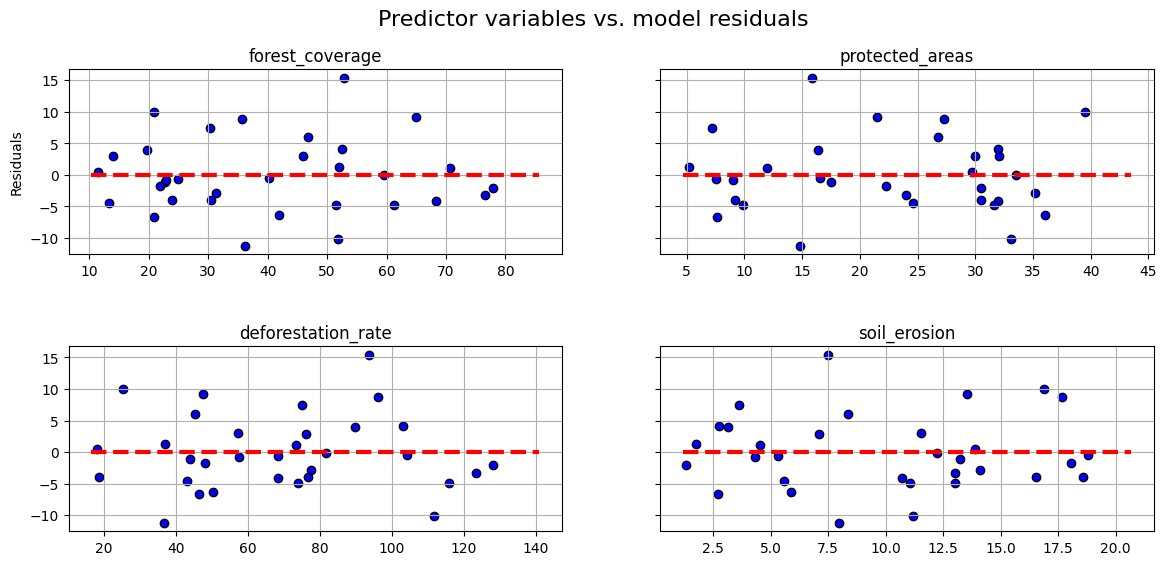

In [16]:
# Plotting predictor variables vs. model residuals
fig, axs = plt.subplots(2, 2, figsize=(14, 6), sharey=True)  # Adjusted to 2 rows and 4 columns
fig.subplots_adjust(hspace=0.5, wspace=0.2)
fig.suptitle('Predictor variables vs. model residuals', fontsize=16)
axs = axs.ravel()

for index, column in enumerate(reduced_matrix):
    if index < len(axs):  # Ensure we don't exceed the number of subplots
        axs[index].set_title("{}".format(column), fontsize=12)
        axs[index].scatter(x=environmental_indicators[column], y=fitted.resid, color='blue', edgecolor='k')
        axs[index].grid(True)
        xmin = min(environmental_indicators[column])
        xmax = max(environmental_indicators[column])
        axs[index].hlines(y=0, xmin=xmin*0.9, xmax=xmax*1.1, color='red', linestyle='--', lw=3)
        if index == 0 or index == 4:
            axs[index].set_ylabel('Residuals')

In the charts above, it is clear that there are residuals present, but we cannot actually see any specific groupings or patterns emerging, which would suggest that the errors are independent. The loose distribution of errors around zero is a clear indication that external influences on the residuals are unlikely.

# **Exercise 7**
Check for homoscedasticity by conducting a Breusch-Pagan test on our model. Interpret the results to determine whether homoscedasticity could possibly be satisfied for our regression model.

In [17]:
# 1. Calculate residuals
residuals = fitted.resid

# 2. Perform Breusch-Pagan Test
bp_test_result = sms.het_breuschpagan(residuals, fitted.model.exog)
print("Breusch-Pagan Test Results:")
print("LM Statistic:", bp_test_result[0])
print("LM-Test p-value:", bp_test_result[1])
print("F-Statistic:", bp_test_result[2])
print("F-Test p-value:", bp_test_result[3])

Breusch-Pagan Test Results:
LM Statistic: 1.1642531323301242
LM-Test p-value: 0.9482604748380201
F-Statistic: 0.19633434902996144
F-Test p-value: 0.9611146316365243


The p-values of both the LM test and the F-test are larger than the typical significance level of 0.05. This indicates that there isn't enough evidence to reject null hypothesis of homoscedasticity. This is good news for our model!

In simpler terms, the variance of the residuals is constant across all values of the predictor variables, which means the model should be relatively reliable in predictions.

Null hypothesis (H₀): Homoscedasticity (equal variance of residuals)

Alternative hypothesis (H₁): Heteroscedasticity (unequal variance)

If p-value < 0.05, reject H₀ → indicates heteroscedasticity is present

If p-value ≥ 0.05, fail to reject H₀ → residuals are homoscedastic

# **Exercise 8**
Check for the normality of residuals by creating a Q-Q plot of the normalised residuals to visually assess their normality.

<Figure size 800x500 with 0 Axes>

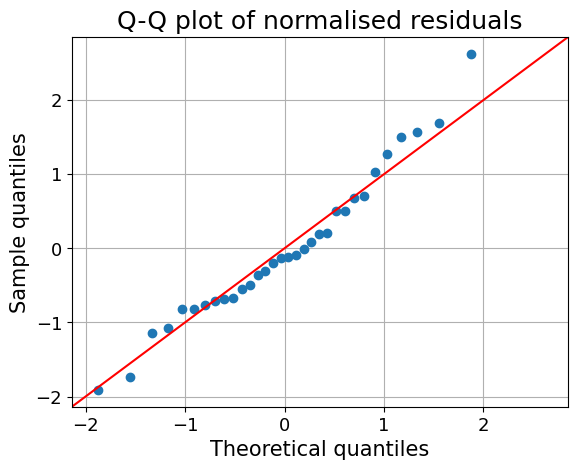

In [20]:
plt.figure(figsize=(8,5))
fig=qqplot(fitted.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalised residuals",fontsize=18)
plt.grid(True)
plt.show()

For the most part, our points lie close to the one-to-one line, which indicates that the residuals are normally distributed. There is however one rogue point on the plot that may warrant further investigation.

# **Question 9**
To ensure the accuracy of our regression model, it's crucial to check for outliers that might significantly affect the model's coefficients and predictions. Use Cook's distance to visually inspect a plot of residuals vs. fitted values by identifying potential outliers.

Interpret the results.

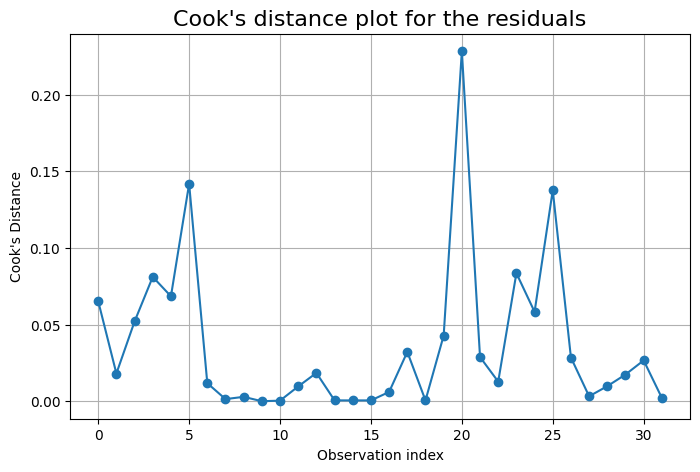

In [21]:
# Calculate Cook's distance
influence = OLSInfluence(fitted)
(c, p) = influence.cooks_distance

# Plot Cook's distance
plt.figure(figsize=(8, 5))
plt.title("Cook's distance plot for the residuals", fontsize=16)
plt.plot(np.arange(len(c)), c, marker='o', linestyle='-')
plt.xlabel('Observation index')
plt.ylabel("Cook's Distance")
plt.grid(True)
plt.show()

In our scenario, none of the distances exceed 1, and when we calculate 4 divided by the number of observations (32), we get 0.125.

There are three points that may demand more examination and influence our model. The values 0.23, 0.14, and 0.14 are all larger than the rule of thumb that can be used to spot outliers.

Ideally, we should train the model again without those observations to observe how they influence it.